In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os
import csv
import numpy as np
import matplotlib.pylab as plt
import pandas as pd  
import seaborn as sns
import xml.etree.ElementTree as ET  
from fnmatch import fnmatch
import collections

In [3]:
row_list = [] # list used to store sentences

In [4]:
def go_deep(x ,line):
	if x.tag== 'w' or x.tag == 'c':
		string = str(x.text)
		string = string.strip()
		string = string + "_"+x.attrib.get('c5')
		string = " " + string
		line = line +string
		#print(line)
		string = ""
		return line
	else :
		for y in x:
			line = go_deep(y ,line)
		return line

In [5]:
def go_deep1(x):
	if x.tag == 's':
		line = "<S>"
		#print(a.tag)
		line = go_deep(x ,line)
		line = line + " " + "<E>"
		#print(line)
		row = [line]		 
		row_list.append(row)
	else :
		for y in x:
			go_deep1(y)

In [6]:
'''
function to generate sentences from root directory
'''

def generate_sentences(root ,filename):

  row_list.clear()
  all_file_paths=list()

  folders=os.listdir(path=root) 
  for folder in folders:
	  f_path=os.path.join(root,folder)
	  files=os.listdir(path=f_path)
	  for file in files:
		  f2_path=os.path.join(f_path,file)
		  all_file_paths.append(f2_path)
    
  for file_path in all_file_paths:
	  tree = ET.parse(file_path)
	  root = tree.getroot()
	  for a in root.findall('wtext'):
		  go_deep1(a)

  with open(filename,'w')as file:
	  writer=csv.writer(file)
	  writer.writerows(row_list) 


In [7]:
generate_sentences('train-corpus' , 'sentences_train.csv')
generate_sentences('test-corpus' , 'sentences_test.csv')

In [8]:
transition_table = {} # transition_table[prev_tag][curr_tag]
emission_table = {} # emission_table[curr_tag][word]
tag_names = [] # [ name1 , name2 ...]
tag_no = {} # tag_no[tag] -> the index of tag
transition_count = {}
emission_count = {}
factor1 = 0.0059   #transition probability for new tag-tag associations 
factor2 = 0.0000000008 #emission probability for new tag-word associations
factor3 = 0 #threshold for selecting tag nodes for a word

In [9]:
path_train = '/gdrive/Shareddrives/AI_Project/sentence_train.csv'
path_test = '/gdrive/Shareddrives/AI_Project/sentence_test.csv'
path_tag_names = '/gdrive/Shareddrives/AI_Project/tag_names.csv'

In [10]:
'''
This cell implements HMM with viterbi . The function takes as input a sentence consisting of word_tag . The function extracts 
the word sequence from this , which is then used to calculate the probable tag sequence for words.
Input - > Sentence
Output - > Tag sequence for the sentence with highest probability
'''


def viterbi(sentence):

	layer_tag = {}
	layer_tags = []
	prev_probs = [1]
	prev_tags = ["start"]
	prev = {}
	curr = {}
	prev["start"] = 1

	word_index = 0
	for word_tag in sentence:

		word = word_tag.split('_')[0]

		curr.clear()
		max_prob_o = 0

		for curr_tag in tag_names:

			prob_max = 0
			prob_max_tag = ""
			curr[curr_tag] = {}
			for prev_tag , prob in prev.items():

				curr_prob = 0
				if prev_tag in transition_table.keys() and curr_tag in transition_table[prev_tag].keys():
					if curr_tag in emission_table.keys() and word in emission_table[curr_tag].keys():
						curr_prob = prob*transition_table[prev_tag][curr_tag]*emission_table[curr_tag][word]
						# probability of a node is product of emission , transition and the probability of previous node
					else:
						curr_prob = prob*transition_table[prev_tag][curr_tag]*factor2
				else:
					curr_prob = prob*factor1*factor2		
				if curr_prob>=prob_max:
					prob_max = curr_prob
					prob_max_tag = prev_tag
				if curr_prob>max_prob_o:
					max_prob_o = curr_prob	

				
			curr[curr_tag]["probability"] = prob_max
			curr[curr_tag]["target"] = prob_max_tag
			
		#print(curr_probs)
		max_prob_o = max_prob_o *factor3

		layer_tag[word_index] = {}
		prev.clear()
		for tag in tag_names:
			if curr[tag]["probability"] >= max_prob_o:
				layer_tag[word_index][tag] = curr[tag]["target"]
				prev[tag] = curr[tag]["probability"]
		word_index = word_index + 1

	#print(prev_tags)
	curr_tag = "end"
	prob_max = 0
	prob_max_tag = ""
	for prev_tag , prob in prev.items():
		
		curr_prob = 0
		if prev_tag in transition_table.keys() and curr_tag in transition_table[prev_tag].keys():
			curr_prob = prob*transition_table[prev_tag][curr_tag]
		else:
			curr_prob = prob*factor1			
		if curr_prob>=prob_max:
			prob_max = curr_prob
			prob_max_tag = prev_tag
	if prob_max == 0:
		prob_max = factor1*factor2		
	
	word_index = word_index -1
	f_tag = prob_max_tag

	final_tag_list = []
	final_tag_list.append(f_tag)

	while word_index>0:

		f_tag = layer_tag[word_index][f_tag]
		final_tag_list.append(f_tag)

		word_index = word_index -1

	final_tag_list.reverse()

	return final_tag_list



In [11]:
'''
Slower version of viterbi , with higher accuracy
Input - > Sentence
Output - > Tag sequence for the sentence with highest probability
'''

def viterbi_acc(sentence):


	layer_tags = []
	prev_probs = [1]
	prev_tags = ["start"]

	word_index = 0
	for word_tag in sentence:

		word = word_tag.split('_')[0]

		curr_probs = []
		curr_tags_selected = []

		for curr_tag in tag_names:

			prob_max = 0
			prob_max_tag = ""
			i = 0
			for prev_tag in prev_tags:

				curr_prob = 0
				if prev_tag in transition_table.keys() and curr_tag in transition_table[prev_tag].keys():
					if curr_tag in emission_table.keys() and word in emission_table[curr_tag].keys():
						curr_prob = prev_probs[i]*transition_table[prev_tag][curr_tag]*emission_table[curr_tag][word]

					else:
						curr_prob = prev_probs[i]*transition_table[prev_tag][curr_tag]*factor2
				else:
					curr_prob = prev_probs[i]*factor1*factor2		
				if curr_prob>=prob_max:
					prob_max = curr_prob
					prob_max_tag = prev_tag

				i = i + 1
			if prob_max == 0 or prob_max == 0.0:
				prob_max = factor1*factor2
			curr_probs.append(prob_max)
			curr_tags_selected.append(prob_max_tag)
		#print(curr_probs)
		layer_tags.append(curr_tags_selected)
		prev_probs = curr_probs
		prev_tags = tag_names
		word_index = word_index + 1

	#print(prev_tags)
	curr_tag = "end"
	prob_max = 0
	prob_max_tag = ""
	i = 0
	for prev_tag in prev_tags:
		
		curr_prob = 0
		if prev_tag in transition_table.keys() and curr_tag in transition_table[prev_tag].keys():
			curr_prob = prev_probs[i]*transition_table[prev_tag][curr_tag]
		else:
			curr_prob = prev_probs[i]*factor1			
		if curr_prob>=prob_max:
			prob_max = curr_prob
			prob_max_tag = prev_tag
		i = i + 1
	if prob_max == 0:
		prob_max = factor1*factor2		
	curr_probs.append(prob_max)
	
	word_index = word_index -1
	f_tag = prob_max_tag

	final_tag_list = []
	final_tag_list.append(f_tag)

	while word_index>0:

		f_no = tag_no[f_tag]
		f_tag = layer_tags[word_index][f_no]
		final_tag_list.append(f_tag)

		word_index = word_index -1

	final_tag_list.reverse()

	return final_tag_list



In [12]:
'''
This cell generates the transition and emission tables based on train data.
The values are normalised to represent probability values
'''

sentence_word_tag = list(csv.reader(open(path_train)))[1:]

#load tables

for sentence in sentence_word_tag:
  sentence = ' '.join(sentence)
  sentence = sentence.split(' ')
  sentence = sentence[1:-1]
  prev_tags = ["start"]
  for word_tag in sentence:
    try:
      word = word_tag.split('_')[0]
      curr_tags = word_tag.split('_')[1].split('-')
    except:
      continue
    for curr_tag in curr_tags:
      for prev_tag in prev_tags:
        if prev_tag not in transition_table:
          transition_table[prev_tag] = {}
          transition_count[prev_tag] = 0
        if curr_tag not in transition_table[prev_tag]:
          transition_table[prev_tag][curr_tag] = 0
        transition_table[prev_tag][curr_tag] = transition_table[prev_tag][curr_tag] + 1
        transition_count[prev_tag] = transition_count[prev_tag] + 1
        if (prev_tag[0]=="start"):
          continue
        if curr_tag not in emission_table:
          emission_table[curr_tag] = {}
          emission_count[curr_tag] = 0
        if word not in emission_table[curr_tag]:
          emission_table[curr_tag][word] = 0
        emission_table[curr_tag][word] = emission_table[curr_tag][word] + 1 
        emission_count[curr_tag] = emission_count[curr_tag] + 1
    prev_tags = curr_tags
  #print(prev_tags)  
  curr_tags = ["end"]
  for curr_tag in curr_tags:
    for prev_tag in prev_tags:
      if prev_tag not in transition_table:
        transition_table[prev_tag] = {}
        transition_count[prev_tag] = 0
      if curr_tag not in transition_table[prev_tag]:
        transition_table[prev_tag][curr_tag] = 0
      transition_table[prev_tag][curr_tag] = transition_table[prev_tag][curr_tag] + 1
      transition_count[prev_tag] = transition_count[prev_tag] + 1

for prev_tag in transition_table:
  for curr_tag in transition_table[prev_tag]:
    transition_table[prev_tag][curr_tag] = transition_table[prev_tag][curr_tag]/transition_count[prev_tag]
for tag in emission_table:
  for word in emission_table[tag]:
    emission_table[tag][word] = emission_table[tag][word]/emission_count[tag]



In [13]:
'''
This cell calculates mean for transition and emission table values
'''

mean1 =0 
cmean1 = 0
mean2 = 0
cmean2 = 0

for key,value in transition_table.items():
  for key2,value2 in transition_table[key].items():
    mean1 = mean1 + value2
    cmean1 = cmean1 + 1
mn1 = mean1 / cmean1    

for key,value in emission_table.items():
  for key2,value2 in emission_table[key].items():
    mean2 = mean2 + value2
    cmean2 = cmean2 + 1
mn2 = mean2 / cmean2    


print(mn1)
print(mn2)

0.019266625233063966
0.00024147895966113324


In [14]:
'''
Read the list of tags into tag_names 
'''

with open( path_tag_names , 'r') as file:
	reader = csv.reader(file)
	i = 0
	for row in reader:
		ro = row[0]
		tag_names.append(ro)
		tag_no[ro] = i
		i = i+1       


In [15]:
sentence_word_tag_test = list(csv.reader(open(path_test)))[1:]

In [16]:
'''
Creates confusion dictionary for creating confusion matrix
'''
confusion_dict = {}

for tag in tag_names:
  confusion_dict[tag]  = {}
  for tag_2 in tag_names:
    confusion_dict[tag][tag_2] = 0

In [17]:
'''
This cell reads test data and runs hmm viterbi.
Prints the accuracy found 
'''

factor1 = 0.0059   
factor2 = 0.0000000008 
factor3 = 0.001

print("factor1 : {}     and factor2 : {}   and factor3 : {}  ".format(factor1,factor2,factor3))

hits = 0
miss = 0
lines = 0
dline = 0
for sentence in sentence_word_tag_test:
    sentence = ' '.join(sentence)
    sentence = sentence.split(' ')	
    sentence = sentence[1:-1]
    pos_tag_seq = viterbi(sentence)
    i = 0
    for word_tag in sentence:
      tag_p = word_tag.split('_')[1].split('-')
      if pos_tag_seq[i] in tag_p:
        hits = hits+1
      else :
        miss = miss +1
      for tag in tag_p:
        confusion_dict[tag][pos_tag_seq[i]] = confusion_dict[tag][pos_tag_seq[i]] +1    

      i= i+1
    lines = lines +1	
    if lines - dline == 5000:
        acc = hits / (hits + miss)
        print("{} : hits = {}  , miss = {} , accuracy = {}".format(lines,hits,miss,acc))
        dline = lines


acc = hits / (hits + miss)
print("Overall accuracy on Test Dataset")
print("hits = {}  , miss = {} , accuracy = {}".format(hits,miss,acc))

factor1 : 0.0059     and factor2 : 8e-10   and factor3 : 0.001  
5000 : hits = 101839  , miss = 2829 , accuracy = 0.9729716818894026
10000 : hits = 176735  , miss = 5471 , accuracy = 0.9699735464254745
15000 : hits = 244214  , miss = 8348 , accuracy = 0.9669467299118633
20000 : hits = 339535  , miss = 11280 , accuracy = 0.9678463007568091
25000 : hits = 437622  , miss = 14199 , accuracy = 0.9685738378694217
30000 : hits = 534339  , miss = 16552 , accuracy = 0.9699541288567067
35000 : hits = 646692  , miss = 19755 , accuracy = 0.9703577328729817
40000 : hits = 785119  , miss = 23699 , accuracy = 0.9706992178710168
45000 : hits = 861405  , miss = 26855 , accuracy = 0.9697667349649878
50000 : hits = 964907  , miss = 30101 , accuracy = 0.9697479819257735
55000 : hits = 1064849  , miss = 33256 , accuracy = 0.9697151001042705
60000 : hits = 1192855  , miss = 37288 , accuracy = 0.9696880769146351
65000 : hits = 1293246  , miss = 40768 , accuracy = 0.9694396010836468
70000 : hits = 1366746  , 

In [18]:

factor1 = 0.0059   
factor2 = 0.0000000008 

print("factor1 : {}     and factor2 : {} ".format(factor1,factor2))


hits = 0
miss = 0
lines = 0
dline = 0
for sentence in sentence_word_tag_test:
    sentence = ' '.join(sentence)
    sentence = sentence.split(' ')	
    sentence = sentence[1:-1]
    pos_tag_seq = viterbi_acc(sentence)
    i = 0
    for word_tag in sentence:
      tag_p = word_tag.split('_')[1].split('-')
      if pos_tag_seq[i] in tag_p:
        hits = hits+1
      else :
        miss = miss +1
      for tag in tag_p:
        confusion_dict[tag][pos_tag_seq[i]] = confusion_dict[tag][pos_tag_seq[i]] +1    

      i= i+1
    lines = lines +1	
    if lines - dline == 5000:
        acc = hits / (hits + miss)
        print("{} : hits = {}  , miss = {} , accuracy = {}".format(lines,hits,miss,acc))
        dline = lines


acc = hits / (hits + miss)
print("Overall accuracy on Test Dataset")
print("hits = {}  , miss = {} , accuracy = {}".format(hits,miss,acc))

factor1 : 0.0059     and factor2 : 8e-10 
5000 : hits = 101836  , miss = 2832 , accuracy = 0.9729430198341422
10000 : hits = 176731  , miss = 5475 , accuracy = 0.9699515932515943
15000 : hits = 244209  , miss = 8353 , accuracy = 0.96692693279274
20000 : hits = 339530  , miss = 11285 , accuracy = 0.9678320482305489
25000 : hits = 437658  , miss = 14163 , accuracy = 0.9686535154408493
30000 : hits = 534407  , miss = 16484 , accuracy = 0.9700775652533804
35000 : hits = 646877  , miss = 19570 , accuracy = 0.9706353243393698
40000 : hits = 785344  , miss = 23474 , accuracy = 0.9709774015909636
45000 : hits = 861746  , miss = 26514 , accuracy = 0.9701506315718371
50000 : hits = 965262  , miss = 29746 , accuracy = 0.97010476297678
55000 : hits = 1065204  , miss = 32901 , accuracy = 0.9700383843075115
60000 : hits = 1193332  , miss = 36811 , accuracy = 0.9700758367116669
65000 : hits = 1293733  , miss = 40281 , accuracy = 0.9698046647186611
70000 : hits = 1367235  , miss = 42755 , accuracy = 0

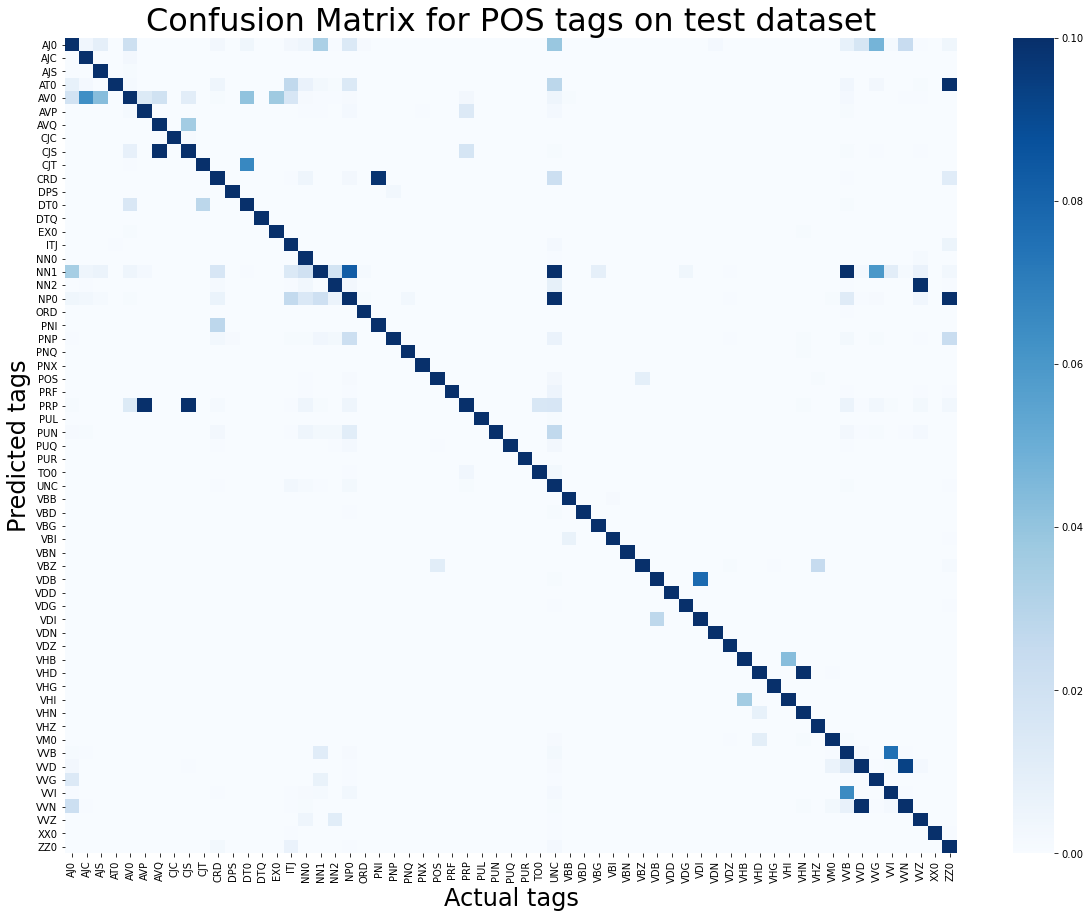

In [19]:
'''
create confusion matrix 
'''

#convert to sorted dictionary

conf_dict = {}

conf_dict = collections.OrderedDict(sorted(confusion_dict.items()))

for key,value in conf_dict.items():
  conf_dict[key] = collections.OrderedDict(sorted(conf_dict[key].items()))

#convert dictionary to dataframe

conf_dataframe = pd.DataFrame.from_dict(conf_dict, orient='columns')
conf_dataframe = conf_dataframe.replace(np.nan, 0)
conf_dataframe = conf_dataframe.sort_index(ascending=True, axis=1)

#noramlise dataframe

conf_dataframe = conf_dataframe/ conf_dataframe.sum(axis=1)
#plot the confusion matrix

plt.figure(figsize = (20,15))
confusion_heatmap = sns.heatmap(conf_dataframe ,xticklabels=1 , yticklabels=1 , cmap = 'Blues' ,vmin=0 ,vmax=0.1)

plt.ylabel('Predicted tags',fontsize =24)
plt.xlabel('Actual tags',fontsize =24)
plt.title('Confusion Matrix for POS tags on test dataset' , fontsize = 32)

#save the confusion matrix

fig = confusion_heatmap.get_figure()
fig.savefig('/gdrive/Shareddrives/AI_Project/Confusion_matrix.png') 